# DnCNN for Image Denoising


Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising
https://arxiv.org/pdf/1608.03981.pdf

Download and unzip dataset

In [1]:
%env CUDA_VISIBLE_DEVICES=2
from pathlib import Path

if not Path("./small_fastmri_pd_3t").is_dir():
    !gdown --id "1y78Ad6WwQpMGtxfEZlp97A0iV98kAiJN"
    !unzip -q small_fastmri_pd_3t.zip && rm small_fastmri_pd_3t.zip
    
if not Path("./dncnn-noiseless.pth").is_file():
    !gdown --id "1azlqmuIkdhcsMQJL_YObF4sEe83D8J8N" 
# Noiseless model weights: https://drive.google.com/file/d/1azlqmuIkdhcsMQJL_YObF4sEe83D8J8N/view?usp=sharing
# Gaussian model weights: 
# Salt&Pepper model weights: 
# Gaussian + Salt&Pepper model weights: 

# TO DO
# 1. Load noiseless and train 10 more epoches with noises, 3 types

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import os
import sys
import numpy as np
import h5py
import pylab as plt
import torch

import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from k_space_reconstruction.nets.dncnn import DnCNNModule
from k_space_reconstruction.datasets.fastmri import FastMRITransform, FastMRIh5Dataset, RandomMaskFunc
from k_space_reconstruction.utils.metrics import pt_msssim, pt_ssim, ssim, nmse, psnr
from k_space_reconstruction.utils.loss import l1_loss, compund_mssim_l1_loss
from k_space_reconstruction.utils.kspace import spatial2kspace, kspace2spatial

print('Available GPUs: ', torch.cuda.device_count())

Available GPUs:  1


# Dataset initialization

In [3]:
torch.manual_seed(42)
np.random.seed(42)

transform = FastMRITransform(
    RandomMaskFunc([0.08], [4]),
    noise_level=1000,
    noise_type='none'
)

train_dataset = FastMRIh5Dataset('small_fastmri_pd_3t/train.h5', transform)
val_dataset = FastMRIh5Dataset('small_fastmri_pd_3t/val.h5', transform)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=12, shuffle=True)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=12)

# Model definition

In [4]:
net = DnCNNModule(
    dncnn_chans=64, 
    dncnn_depth=10, 
    criterion=compund_mssim_l1_loss, 
    verbose_batch=50, 
    optimizer='Adam',
    lr=1e-3,
    lr_step_size=5,
    lr_gamma=1.0,
    weight_decay=0.0
)

# Tensorboard logging

In [5]:
%load_ext tensorboard
%tensorboard --logdir logs/ --port 8001

# Init trainer

In [5]:
trainer = pl.Trainer(
    gpus=1, max_epochs=50,
    accumulate_grad_batches=2,
    terminate_on_nan=True, 
    default_root_dir='logs/DnCNN',
    callbacks=[
        pl.callbacks.ModelCheckpoint(
            save_last=True,
            save_top_k=4, 
            monitor='val_loss', 
            filename='{epoch}-{ssim:.4f}-{psnr:.4f}-{nmse:.5f}'
        ),
        pl.callbacks.LearningRateMonitor(logging_interval='epoch'),
        pl.callbacks.GPUStatsMonitor(temperature=True)
    ]
);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


# Train model

In [7]:
trainer.fit(net, train_dataloader=train_generator, val_dataloaders=val_generator)


  | Name             | Type                 | Params
----------------------------------------------------------
0 | net              | DnCNN                | 297 K 
1 | NMSE             | DistributedMetricSum | 0     
2 | SSIM             | DistributedMetricSum | 0     
3 | PSNR             | DistributedMetricSum | 0     
4 | ValLoss          | DistributedMetricSum | 0     
5 | TotExamples      | DistributedMetricSum | 0     
6 | TotSliceExamples | DistributedMetricSum | 0     


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saving latest checkpoint...


1

# Test model
Load best checkpoint, inference on val dataset and save predictions to .h5 file in logs directory

In [6]:
!ls "logs/DnCNN/lightning_logs/version_0/checkpoints/"

'epoch=44-ssim=0.7704-psnr=28.8372-nmse=0.01518.ckpt'
'epoch=47-ssim=0.7725-psnr=28.9456-nmse=0.01476.ckpt'
'epoch=48-ssim=0.7749-psnr=28.9120-nmse=0.01489.ckpt'
'epoch=49-ssim=0.7742-psnr=28.9415-nmse=0.01480.ckpt'
 last.ckpt


In [11]:
net = net.load_from_checkpoint('logs/DnCNN/lightning_logs/version_0/checkpoints/last.ckpt').eval()

In [12]:
trainer.test(net, val_generator)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------


1

In [13]:
hf_pred = h5py.File('logs/DnCNN/2021-05-17 17:15:53.184451.h5')
hf_gt = h5py.File('small_fastmri_pd_3t/val.h5')

# Val metrics

In [11]:
net.net.load_state_dict(torch.load('dncnn-noiseless.pth'))
net = net.eval()

In [12]:
trainer.test(net, val_generator)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------


1

In [13]:
hf_pred = h5py.File('logs/DnCNN/2021-05-18 07:13:14.640521.h5')
hf_gt = h5py.File('small_fastmri_pd_3t/val.h5')

In [14]:
ssim_vals = []
nmse_vals = []
psnr_vals = []
for k in hf_pred.keys():
    ks = hf_gt[k][:] * 1e6
    gt = np.stack([kspace2spatial(k) for k in ks])
    pred = hf_pred[k][:,0]
    ssim_vals.append(ssim(gt, pred))
    nmse_vals.append(nmse(gt, pred))
    psnr_vals.append(psnr(gt, pred))
ssim_vals = np.array(ssim_vals)
nmse_vals = np.array(nmse_vals)
psnr_vals = np.array(psnr_vals)

np.mean(ssim_vals), np.mean(nmse_vals), np.mean(psnr_vals)

(0.7690872956000397, 0.015700103187944854, 29.872916735655508)

## Saving Weights of the Model 

In [17]:
torch.save(net.net.state_dict(), 'dncnn-noiseless.pth')

### Gaussian Noise

In [30]:
torch.manual_seed(42)
np.random.seed(42)

transform = FastMRITransform(
    RandomMaskFunc([0.08], [4]),
    noise_level=100,
    noise_type='normal'
)

val_dataset = FastMRIh5Dataset('small_fastmri_pd_3t/val.h5', transform)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=12)

net.net.load_state_dict(torch.load('dncnn-with-gaussian.pth'))
net = net.eval()

trainer.test(net, val_generator)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------


1

In [29]:
hf_pred = h5py.File('logs/DnCNN/2021-05-18 08:59:25.744683.h5')
hf_gt = h5py.File('small_fastmri_pd_3t/val.h5')

ssim_vals = []
nmse_vals = []
psnr_vals = []
for k in hf_pred.keys():
    ks = hf_gt[k][:] * 1e6
    gt = np.stack([kspace2spatial(k) for k in ks])
    pred = hf_pred[k][:,0]
    ssim_vals.append(ssim(gt, pred))
    nmse_vals.append(nmse(gt, pred))
    psnr_vals.append(psnr(gt, pred))
ssim_vals = np.array(ssim_vals)
nmse_vals = np.array(nmse_vals)
psnr_vals = np.array(psnr_vals)

np.mean(ssim_vals), np.mean(nmse_vals), np.mean(psnr_vals)

(0.6676438163001183, 0.02154702458780285, 28.512963682318848)

### Salt&Pepper Noise

In [32]:
torch.manual_seed(42)
np.random.seed(42)

transform = FastMRITransform(
    RandomMaskFunc([0.08], [4]),
    noise_level=5e4,
    noise_type='salt'
)

val_dataset = FastMRIh5Dataset('small_fastmri_pd_3t/val.h5', transform)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=12)

net.net.load_state_dict(torch.load('dncnn-with-salt.pth'))
net = net.eval()

trainer.test(net, val_generator)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------


1

In [33]:
hf_pred = h5py.File('logs/DnCNN/2021-05-18 09:00:25.036328.h5')
hf_gt = h5py.File('small_fastmri_pd_3t/val.h5')

ssim_vals = []
nmse_vals = []
psnr_vals = []
for k in hf_pred.keys():
    ks = hf_gt[k][:] * 1e6
    gt = np.stack([kspace2spatial(k) for k in ks])
    pred = hf_pred[k][:,0]
    ssim_vals.append(ssim(gt, pred))
    nmse_vals.append(nmse(gt, pred))
    psnr_vals.append(psnr(gt, pred))
ssim_vals = np.array(ssim_vals)
nmse_vals = np.array(nmse_vals)
psnr_vals = np.array(psnr_vals)

np.mean(ssim_vals), np.mean(nmse_vals), np.mean(psnr_vals)

(0.3955919860898189, 0.08274958656389439, 23.24755016355769)

### Gaussian + Salt&Pepper Noise

In [34]:
torch.manual_seed(42)
np.random.seed(42)

transform = FastMRITransform(
    RandomMaskFunc([0.08], [4]),
    noise_level=5e4,
    noise_type='normal_and_salt'
)

val_dataset = FastMRIh5Dataset('small_fastmri_pd_3t/val.h5', transform)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=12)

net.net.load_state_dict(torch.load('dncnn-with-gaussian-salt.pth'))
net = net.eval()

trainer.test(net, val_generator)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------


1

In [35]:
hf_pred = h5py.File('logs/DnCNN/2021-05-18 09:00:51.678245.h5')
hf_gt = h5py.File('small_fastmri_pd_3t/val.h5')

ssim_vals = []
nmse_vals = []
psnr_vals = []
for k in hf_pred.keys():
    ks = hf_gt[k][:] * 1e6
    gt = np.stack([kspace2spatial(k) for k in ks])
    pred = hf_pred[k][:,0]
    ssim_vals.append(ssim(gt, pred))
    nmse_vals.append(nmse(gt, pred))
    psnr_vals.append(psnr(gt, pred))
ssim_vals = np.array(ssim_vals)
nmse_vals = np.array(nmse_vals)
psnr_vals = np.array(psnr_vals)

np.mean(ssim_vals), np.mean(nmse_vals), np.mean(psnr_vals)

(0.3467734232554068, 0.10609053877619948, 22.3551460802928)

In [36]:
hf_pred.keys()

<KeysViewHDF5 ['file1000033.h5', 'file1000041.h5', 'file1000108.h5', 'file1000182.h5', 'file1000190.h5', 'file1000277.h5', 'file1000389.h5', 'file1000464.h5', 'file1000477.h5', 'file1000625.h5', 'file1000635.h5', 'file1000660.h5', 'file1000697.h5', 'file1000702.h5', 'file1000735.h5', 'file1000759.h5', 'file1000769.h5', 'file1000831.h5', 'file1000926.h5', 'file1000976.h5', 'file1001057.h5', 'file1001064.h5', 'file1001077.h5', 'file1001126.h5', 'file1001163.h5', 'file1001170.h5', 'file1001184.h5', 'file1001202.h5', 'file1001221.h5', 'file1001298.h5', 'file1001331.h5', 'file1001339.h5', 'file1001381.h5', 'file1001444.h5', 'file1001458.h5', 'file1001497.h5', 'file1001506.h5', 'file1001585.h5', 'file1001650.h5', 'file1001668.h5', 'file1001715.h5', 'file1001759.h5', 'file1001763.h5', 'file1001893.h5', 'file1001930.h5', 'file1002021.h5', 'file1002187.h5', 'file1002252.h5', 'file1002351.h5', 'file1002382.h5', 'file1002417.h5', 'file1002546.h5', 'file1002570.h5']>

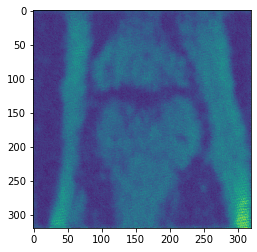

In [39]:
plt.imshow(hf_pred['file1000033.h5'][4,0])